### Combine the data from several files

In [1]:
import json
import numpy as np
from scipy import stats
import itertools
from simulate import find_mean_std_mse
import matplotlib.pyplot as plt
import matplotlib as mpl


In [2]:
#%matplotlib notebook
#%matplotlib inline

#play with this for better figure sizes 
mpl.rcParams['figure.figsize'] = (7,7)

In [3]:
PATH = "data_experiments/"

In [4]:

def get_percentile_confidence_bounds(values):
    return np.percentile(values, 10), np.median(values), np.percentile(values, 90)
    
print(get_percentile_confidence_bounds([1, 10, 3, 80, 4, 5, 8, 12, 13, 4, 7]))

def plot_mean_and_confidence(plot_range, mean, mean_label, confidence_interval, 
                             confidence_interval_title):
    """
    Plot the mean and some kind of confidence interval (standard deviation or
    mean-squared-error)
    
    Parameters:
    ----------
    plot_range: iterable
    mean: an iterable
        the mean of the values at that point
    confidence_interval: an iterable
        Representing the  interval of confidence in that point. 
        The iterable should have length plot_range.
    confidence_interval_title: a string
    
    """
    
    lower_bound = np.array(mean)-np.array(confidence_interval)
    upper_bound = np.array(mean)+np.array(confidence_interval)
    plt.plot(plot_range, mean, label=mean_label)
    if confidence_interval_title:
        plt.fill_between(plot_range, lower_bound, upper_bound, 
                         label='{}'.format(confidence_interval_title),
                         alpha=0.2)
    else:
        plt.fill_between(plot_range, lower_bound, upper_bound, alpha=0.2)
        
        
def plot_results(*args, **kwargs):
    """plot results from simulations
    
    Parameters:
        args: 1 or more dicts. The dicts should have for the keys numerical
            input values and for the values iterables of numbers.
        kwargs: at least the arguments xlabel, ylabel, title
        
    """
    for argument in args:
        data, meta_dict = argument
        variable_range, mean, std, batches_std = (
            find_mean_std_mse(data, 10)
        )
        
        if kwargs['std_of_batches']: 
            plot_mean_and_confidence(variable_range, mean, meta_dict['mean_label'], 
                                     batches_std, "batches stdev")
        else:
            plot_mean_and_confidence(variable_range, mean, meta_dict['mean_label'], 
                                     std, "stdev")
    
    plt.xlabel(kwargs['xlabel'])
    plt.ylabel(kwargs['ylabel'])
    plt.legend()
    plt.title(kwargs['title'])
    plt.show()

(3.0, 7.0, 13.0)


### load the data for the maximum nudges

In [5]:
def dict_keys_from_string_to_int(dictionary):
    return {int(k):v for k,v in dictionary.items()}

def files_to_dict(file_names):
    """ Load the data from the files and make keys into ints"""
    dictionaries = []
    for file_name in file_names:
        with open(file_name, 'r') as f:
            dictionaries.append(json.load(f))

    dictionaries = [dict_keys_from_string_to_int(i) for i in dictionaries]
    return dictionaries

def compare_settings(value_to_scores, min_value, max_value):
    value_to_average_scores = {}
    for i in range(min_value, max_value+1, 1):
        average_impacts = []
        for count, dirichlet_dict in enumerate(value_to_scores):
            try:
                average_impacts.append(np.mean(dirichlet_dict[i]))
            except KeyError:
                print("the {} file has variable {} missing".format(i, count))

        value_to_average_scores[i] = average_impacts

    return value_to_average_scores

def flip_sign_values_dict(dictionary):
    for key, values in dictionary.items():
        dictionary[key] = [-value for value in values]
        
    return dictionary

def find_max_scores_per_value(dictionaries, min_value, max_value):
    value_to_maximum_scores = {}
    for i in range(min_value, max_value+1, 1):
        impacts = []
        for count, dictionary in enumerate(dictionaries):
            try:
                impacts.append(dictionary[i])
            except KeyError:
                print("the {} file has variable {} missing".format(i, count))

        max_impacts = [max(scores) for scores in list(zip(*impacts))]
        value_to_maximum_scores[i] = max_impacts

    return value_to_maximum_scores

### get maximum nudge impacts

In [6]:
def get_max_impacts(number_of_vars, number_of_states, percentage_max_entropy_size, 
                    nudge_type, dist_start, dist_end):
    filename_to_save_impacts =  "impacts_{}var_{}states_{}entropy_{}_nudge_dists{}-{}.json".format(
        number_of_vars, number_of_states, percentage_max_entropy_size, nudge_type, dist_start, dist_end
    )
    with open("data_experiments/" + filename_to_save_impacts, 'r') as f:
        impacts = json.load(f)
        
    return impacts



individual
2
3
4
5
6
7
local
2
3
4
5
6
7
synergistic
2
3
4
5
6
7
global
2
3
4
5
6
7


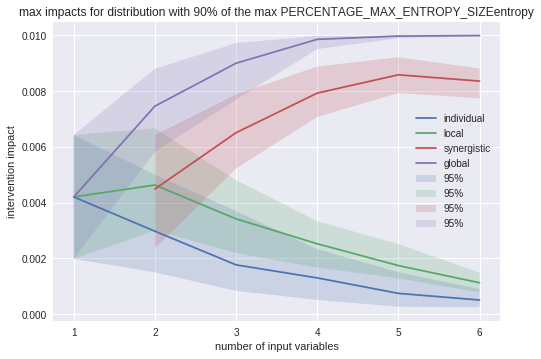

In [7]:
import seaborn as sns
from scipy import stats

NUMBER_OF_STATES = 3
PERCENTAGE_MAX_ENTROPY_SIZE = 90

#nudge_types = ["individual", "local", "synergistic", "global"]
nudge_types = ["individual", "local", "synergistic", "global"]


nudge_impacts = {}
numbers_of_var = [2, 3, 4, 5, 6, 7]
for nudge_type in nudge_types:
    print(nudge_type)
    var_to_impacts = {}
    for number_of_var in numbers_of_var:
        print(number_of_var)
        if nudge_type == "synergistic" and number_of_var==2:
            continue
        if nudge_type == "local" and number_of_var==2:
            impacts = get_max_impacts(
                number_of_var, NUMBER_OF_STATES, PERCENTAGE_MAX_ENTROPY_SIZE, 
                "individual", dist_start=100, dist_end=200
            )
        else:
            impacts = get_max_impacts(
                number_of_var, NUMBER_OF_STATES, PERCENTAGE_MAX_ENTROPY_SIZE, 
                nudge_type, dist_start=100, dist_end=200
            )

            if nudge_type == "local" or nudge_type == "synergistic":
                impacts = [-1*impact for impact in impacts]
                
        
#         print(stats.shapiro(impacts))
#         print(stats.normaltest(impacts))
#         sns.distplot(impacts)
#         plt.show()
        
        var_to_impacts[number_of_var] = impacts
        
    variable_range, mean, std, batches_std = (
        find_mean_std_mse(var_to_impacts, 10)
    )
    
    std2 = list(2*np.array(std))
    #plot_mean_and_confidence(variable_range, mean, nudge_type, std2, None)
    
    #add confidence intervals based on percentiles
    lower_bound, median, upper_bound = [], [], []
    for variable_number, impacts in var_to_impacts.items():
        lower_bound.append(np.percentile(impacts, 2.5))
        median.append(np.median(impacts)) 
        upper_bound.append(np.percentile(impacts, 97.5))
        
    nudge_impacts[nudge_type] = median
    plot_range = [i-1 for i in list(var_to_impacts.keys())]
    plt.plot(plot_range, median, label=nudge_type)
    plt.fill_between(plot_range, lower_bound, upper_bound, 
                     label='{}'.format("95%"), alpha=0.2)
    
    
plt.xlabel("number of input variables")
plt.ylabel("intervention impact")
plt.title("max impacts for distribution with {}% of the max PERCENTAGE_MAX_ENTROPY_SIZEentropy".format(PERCENTAGE_MAX_ENTROPY_SIZE))
plt.legend()
plt.show()



Analytical results

In [8]:
#print(nudge_impacts)
analytical_estimate_individual = [n / (2**n - 1.0) for n in range(1, 7)]
analytical_estimate_synergy = [((2**n - 1.0)-n) / (2**n - 1.0) for n in range(1, 7)]

#print(np.array(nudge_impacts["individual"] / np.array(nudge_impacts["global"])))
#print(analytical_estimate_individual)
#print((np.array(nudge_impacts["individual"] / np.array(nudge_impacts["global"])))/analytical_estimate_individual)

print(analytical_estimate_synergy[1:])
print(np.array(nudge_impacts["synergistic"])/0.01)

#print((analytical_estimate[1:]*np.array(nudge_impacts["global"][1:]))/0.01)

[0.3333333333333333, 0.5714285714285714, 0.7333333333333333, 0.8387096774193549, 0.9047619047619048]
[ 0.44887664  0.65097273  0.79302078  0.85866986  0.83611514]


In [9]:
import seaborn as sns
from scipy import stats

NUMBER_OF_STATES = 3


#nudge_types = ["individual", "local", "synergistic", "global"]
nudge_types = ["individual", "local", "synergistic", "global"]
numbers_of_var = [2, 3, 4, 5, 6, 7]
percentages_max_entropy = [75, 80, 85, 90]

entropy_percentage_to_nudge_impacts = {}
for percentage_max_entropy in percentages_max_entropy: 
    nudge_impacts = {}
    for nudge_type in nudge_types:
        print(nudge_type)
        var_to_impacts = {}
        for number_of_var in numbers_of_var:
            print(number_of_var)
            if nudge_type == "synergistic" and number_of_var==2:
                continue
            if nudge_type == "local" and number_of_var==2:
                impacts = get_max_impacts(
                    number_of_var, NUMBER_OF_STATES, percentage_max_entropy, 
                    "individual", dist_start=100, dist_end=200
                )
            else:
                impacts = get_max_impacts(
                    number_of_var, NUMBER_OF_STATES, percentage_max_entropy, 
                    nudge_type, dist_start=100, dist_end=200
                )

                if nudge_type == "local" or nudge_type == "synergistic":
                    impacts = [-1*impact for impact in impacts]


    #         print(stats.shapiro(impacts))
    #         print(stats.normaltest(impacts))
    #         sns.distplot(impacts)
    #         plt.show()

            var_to_impacts[number_of_var] = impacts

        variable_range, mean, std, batches_std = (
            find_mean_std_mse(var_to_impacts, 10)
        )

        std2 = list(2*np.array(std))
        #plot_mean_and_confidence(variable_range, mean, nudge_type, std2, None)

        #add confidence intervals based on percentiles
        lower_bound, median, upper_bound = [], [], []
        for variable_number, impacts in var_to_impacts.items():
            lower_bound.append(np.percentile(impacts, 2.5))
            median.append(np.median(impacts)) 
            upper_bound.append(np.percentile(impacts, 97.5))

        nudge_impacts[nudge_type] = {
            "median": median,
            "lower_bound": lower_bound,
            "upper_bound": upper_bound
        }
    
    entropy_percentage_to_nudge_impacts[percentage_max_entropy] = nudge_impacts 
    
#         plot_range = [i-1 for i in list(var_to_impacts.keys())]
#         plt.plot(plot_range, median, label=nudge_type)
#         plt.fill_between(plot_range, lower_bound, upper_bound, 
#                          label='{}'.format("95%"), alpha=0.2)
    
# plt.xlabel("number of input variables")
# plt.ylabel("intervention impact")
# plt.title("max impacts for distribution with {}% of the max PERCENTAGE_MAX_ENTROPY_SIZEentropy".format(PERCENTAGE_MAX_ENTROPY_SIZE))
# plt.legend()
# plt.show()


individual
2
3
4
5
6
7
local
2
3
4
5
6
7
synergistic
2
3
4
5
6
7
global
2
3
4
5
6
7
individual
2
3
4
5
6
7
local
2
3
4
5
6
7
synergistic
2
3
4
5
6
7
global
2
3
4
5
6
7
individual
2
3
4
5
6
7
local
2
3
4
5
6
7
synergistic
2
3
4
5
6
7
global
2
3
4
5
6
7
individual
2
3
4
5
6
7
local
2
3
4
5
6
7
synergistic
2
3
4
5
6
7
global
2
3
4
5
6
7


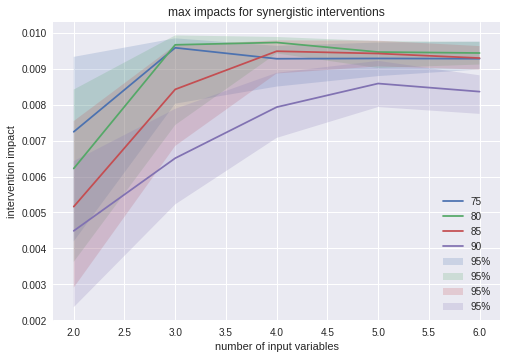

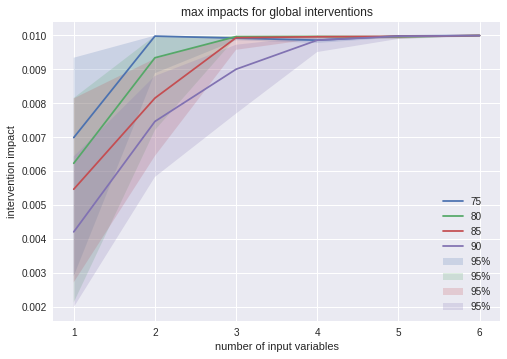

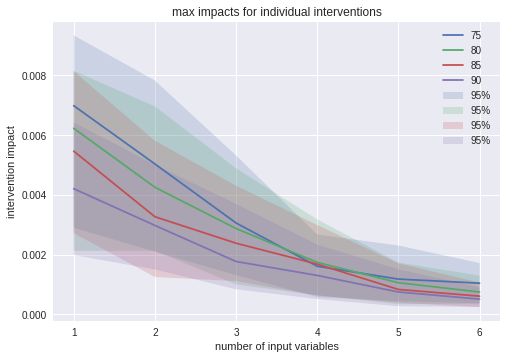

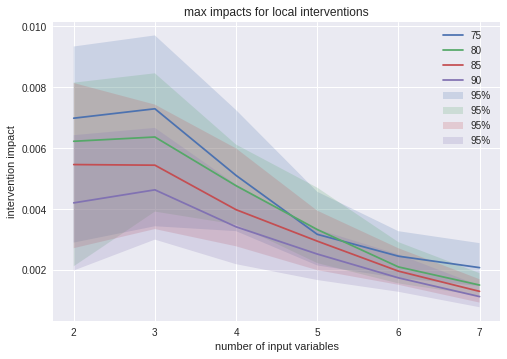

In [10]:
from collections import OrderedDict
import operator

nudge_type_to_entropy_dict = {} 
for entropy_percentage, nudge_impact_dict in entropy_percentage_to_nudge_impacts.items():
    for nudge_type, impacts in nudge_impact_dict.items():
        if nudge_type in nudge_type_to_entropy_dict:
            nudge_type_to_entropy_dict[nudge_type][entropy_percentage] = impacts
        else:
            nudge_type_to_entropy_dict[nudge_type] = {entropy_percentage:impacts}
            
for nudge_type, entropy_to_impacts in nudge_type_to_entropy_dict.items():
    nudge_type_to_entropy_dict[nudge_type] = OrderedDict(
        sorted(entropy_to_impacts.items(), key=operator.itemgetter(0))
    )

for nudge_type, entropy_to_impacts in nudge_type_to_entropy_dict.items():
    for entropy_percentage, var_to_impacts in entropy_to_impacts.items():
        if nudge_type == "individual" or nudge_type == "global":
            plot_range = list(range(1, len(var_to_impacts["median"])+1, 1))
        else:
            plot_range = list(range(2, len(var_to_impacts["median"])+2, 1))
            
        plt.plot(plot_range, var_to_impacts["median"], label=entropy_percentage)
        plt.fill_between(plot_range, var_to_impacts["lower_bound"], var_to_impacts["upper_bound"], 
                         label='{}'.format("95%"), alpha=0.2)
    
    plt.xlabel("number of input variables")
    plt.ylabel("intervention impact")
    plt.title("max impacts for {} interventions".format(nudge_type))
    plt.legend()
    plt.show()

    
    

### Validate results maximum nudge impacts using a different process to generate the distributions

individual
2
3
4
5
6
7
local
2
3
4
5
6
7
synergistic
2
3
4
5
6
7
global
2
3
4
5
6
7


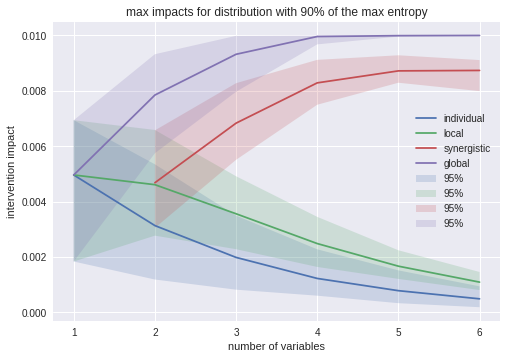

In [15]:
NUMBER_OF_STATES = 3
PERCENTAGE_MAX_ENTROPY_SIZE = 90
nudge_types = ["individual", "local", "synergistic", "global"]
numbers_of_var = [2, 3, 4, 5, 6, 7]
for nudge_type in nudge_types:
    print(nudge_type)
    var_to_impacts = {}
    for number_of_var in numbers_of_var:
        print(number_of_var)
        if nudge_type == "synergistic" and number_of_var==2:
            continue
        if nudge_type == "local" and number_of_var==2:
            impacts = get_max_impacts(
                number_of_var, NUMBER_OF_STATES, PERCENTAGE_MAX_ENTROPY_SIZE, 
                "individual", dist_start=200, dist_end=300
            )
        else:
            impacts = get_max_impacts(
                number_of_var, NUMBER_OF_STATES, PERCENTAGE_MAX_ENTROPY_SIZE, 
                nudge_type, dist_start=200, dist_end=300
            )

            if nudge_type == "local" or nudge_type == "synergistic":
                impacts = [-1*impact for impact in impacts]

        var_to_impacts[number_of_var] = impacts
        
        #testing for normality 
#         print(stats.shapiro(impacts))
#         print(stats.normaltest(impacts))
#         sns.distplot(impacts)
#         plt.show()
        
    variable_range, mean, std, batches_std = (
        find_mean_std_mse(var_to_impacts, 10)
    )
    std2 = list(2*np.array(std))
    #plot_mean_and_confidence(variable_range, mean, nudge_type, std2, None)
    
    #add confidence intervals based on percentiles
    lower_bound, median, upper_bound = [], [], []
    for variable_number, impacts in var_to_impacts.items():
        lower_bound.append(np.percentile(impacts, 2.5))
        median.append(np.median(impacts)) 
        upper_bound.append(np.percentile(impacts, 97.5))
        
    plot_range = [i-1 for i in list(var_to_impacts.keys())]
    plt.plot(plot_range, median, label=nudge_type)
    plt.fill_between(plot_range, lower_bound, upper_bound, 
                     label='{}'.format("95%"), alpha=0.2)
    
plt.xlabel("number of variables")
plt.ylabel("intervention impact")
plt.title("max impacts for distribution with {}% of the max entropy".format(PERCENTAGE_MAX_ENTROPY_SIZE))
plt.legend()
plt.show()


In [16]:
import seaborn as sns
from scipy import stats

NUMBER_OF_STATES = 3


#nudge_types = ["individual", "local", "synergistic", "global"]
nudge_types = ["individual", "local", "synergistic", "global"]
numbers_of_var = [2, 3, 4, 5, 6, 7]
percentages_max_entropy = [75, 80, 85, 90]

entropy_percentage_to_nudge_impacts_validate = {}
for percentage_max_entropy in percentages_max_entropy: 
    nudge_impacts = {}
    for nudge_type in nudge_types:
        print(nudge_type)
        var_to_impacts = {}
        for number_of_var in numbers_of_var:
            print(number_of_var)
            if nudge_type == "synergistic" and number_of_var==2:
                continue
            if nudge_type == "local" and number_of_var==2:
                impacts = get_max_impacts(
                    number_of_var, NUMBER_OF_STATES, percentage_max_entropy, 
                    "individual", dist_start=200, dist_end=300
                )
            else:
                impacts = get_max_impacts(
                    number_of_var, NUMBER_OF_STATES, percentage_max_entropy, 
                    nudge_type, dist_start=200, dist_end=300
                )

                if nudge_type == "local" or nudge_type == "synergistic":
                    impacts = [-1*impact for impact in impacts]


    #         print(stats.shapiro(impacts))
    #         print(stats.normaltest(impacts))
    #         sns.distplot(impacts)
    #         plt.show()

            var_to_impacts[number_of_var] = impacts

        variable_range, mean, std, batches_std = (
            find_mean_std_mse(var_to_impacts, 10)
        )

        std2 = list(2*np.array(std))
        #plot_mean_and_confidence(variable_range, mean, nudge_type, std2, None)

        #add confidence intervals based on percentiles
        lower_bound, median, upper_bound = [], [], []
        for variable_number, impacts in var_to_impacts.items():
            lower_bound.append(np.percentile(impacts, 2.5))
            median.append(np.median(impacts)) 
            upper_bound.append(np.percentile(impacts, 97.5))

        nudge_impacts[nudge_type] = {
            "median": median,
            "lower_bound": lower_bound,
            "upper_bound": upper_bound
        }
    
#     print(nudge_impacts)
    entropy_percentage_to_nudge_impacts_validate[percentage_max_entropy] = nudge_impacts 
    
print(entropy_percentage_to_nudge_impacts_validate[80]["global"])
print(entropy_percentage_to_nudge_impacts_validate[75]["global"])
#         plot_range = [i-1 for i in list(var_to_impacts.keys())]
#         plt.plot(plot_range, median, label=nudge_type)
#         plt.fill_between(plot_range, lower_bound, upper_bound, 
#                          label='{}'.format("95%"), alpha=0.2)
    
# plt.xlabel("number of input variables")
# plt.ylabel("intervention impact")
# plt.title("max impacts for distribution with {}% of the max PERCENTAGE_MAX_ENTROPY_SIZEentropy".format(PERCENTAGE_MAX_ENTROPY_SIZE))
# plt.legend()
# plt.show()


individual
2
3
4
5
6
7
local
2
3
4
5
6
7
synergistic
2
3
4
5
6
7
global
2
3
4
5
6
7
individual
2
3
4
5
6
7
local
2
3
4
5
6
7
synergistic
2
3
4
5
6
7
global
2
3
4
5
6
7
individual
2
3
4
5
6
7
local
2
3
4
5
6
7
synergistic
2
3
4
5
6
7
global
2
3
4
5
6
7
individual
2
3
4
5
6
7
local
2
3
4
5
6
7
synergistic
2
3
4
5
6
7
global
2
3
4
5
6
7
{'lower_bound': [0.0025084472631133762, 0.0079117238739755819, 0.0099999991403153399, 0.0099999999912236924, 0.0099999999327082499, 0.009999999950438104], 'median': [0.0066234103286281244, 0.0099998324918947369, 0.0099999999999992248, 0.0099999999999943034, 0.0099999999987361553, 0.0099999999968919603], 'upper_bound': [0.0093225708882313414, 0.01, 0.01, 0.0099999999999999985, 0.0099999999999969315, 0.0099999999999444335]}
{'lower_bound': [0.0029494668038005023, 0.0093513691662752158, 0.0099999999999999204, 0.01, 0.0099999999999999794, 0.009999999999999622], 'median': [0.0073894365999708179, 0.01, 0.01, 0.01, 0.01, 0.0099999999999999985], 'upper_bound': [0.

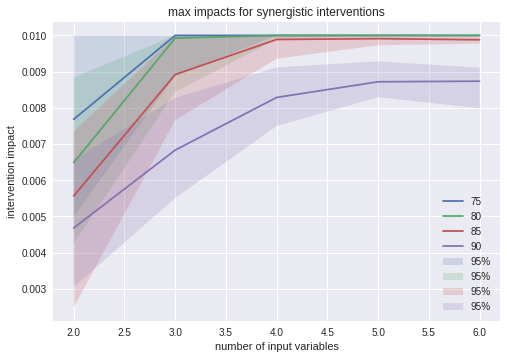

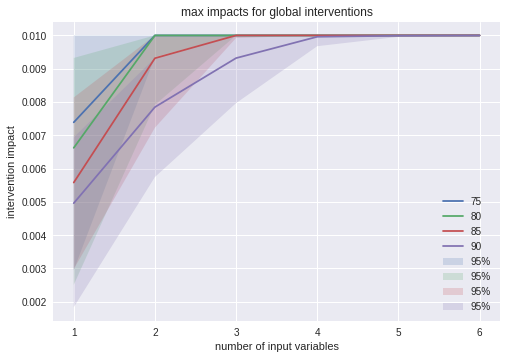

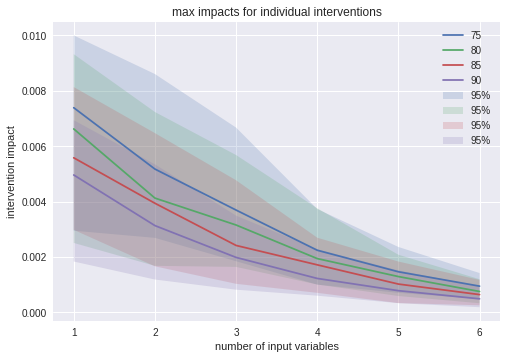

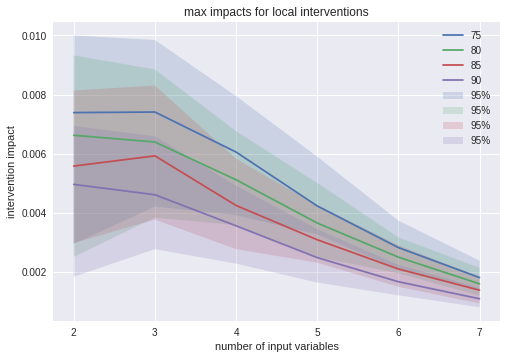

In [17]:
from collections import OrderedDict
import operator

nudge_type_to_entropy_dict_validate = {} 
for entropy_percentage, nudge_impact_dict in entropy_percentage_to_nudge_impacts_validate.items():
#     print(entropy_percentage)
#     print(nudge_impact_dict)
    for nudge_type, impacts in nudge_impact_dict.items():
#         print(nudge_type)
        if nudge_type in nudge_type_to_entropy_dict_validate:
            nudge_type_to_entropy_dict_validate[nudge_type][entropy_percentage] = impacts
        else:
            nudge_type_to_entropy_dict_validate[nudge_type] = {entropy_percentage:impacts}
            
for nudge_type, entropy_to_impacts in nudge_type_to_entropy_dict_validate.items():
    nudge_type_to_entropy_dict_validate[nudge_type] = OrderedDict(
        sorted(entropy_to_impacts.items(), key=operator.itemgetter(0))
    )

# print(nudge_type_to_entropy_dict_validate["individual"])
# print(nudge_type_to_entropy_dict_validate["global"])
    
for nudge_type, entropy_to_impacts in nudge_type_to_entropy_dict_validate.items():
    for entropy_percentage, var_to_impacts in entropy_to_impacts.items():
        if nudge_type == "individual" or nudge_type == "global":
            plot_range = list(range(1, len(var_to_impacts["median"])+1, 1))
        else:
            plot_range = list(range(2, len(var_to_impacts["median"])+2, 1))
            
        plt.plot(plot_range, var_to_impacts["median"], label=entropy_percentage)
        plt.fill_between(plot_range, var_to_impacts["lower_bound"], var_to_impacts["upper_bound"], 
                         label='{}'.format("95%"), alpha=0.2)
    
    plt.xlabel("number of input variables")
    plt.ylabel("intervention impact")
    plt.title("max impacts for {} interventions".format(nudge_type))
    plt.legend()
    plt.show()


### Get random nudge impacts

In [18]:
def get_random_impacts(number_of_vars, number_of_states, percentage_max_entropy_size, 
                       nudge_type, dist_start, dist_end):
    filename_to_save_impacts =  "random_impacts_{}var_{}states_{}entropy_{}_nudge_dists{}-{}.json".format(
        number_of_vars, number_of_states, percentage_max_entropy_size, nudge_type, dist_start, dist_end 
    )
    with open("data_experiments/" + filename_to_save_impacts, 'r') as f:
        impacts = json.load(f)
        
    return impacts



individual
2
3
4
5
6
7
local
2
3
4
5
6
7
synergistic
2
3
4
5
6
7
global
2
3
4
5
6
7
focused
2
3
4
5
6
7


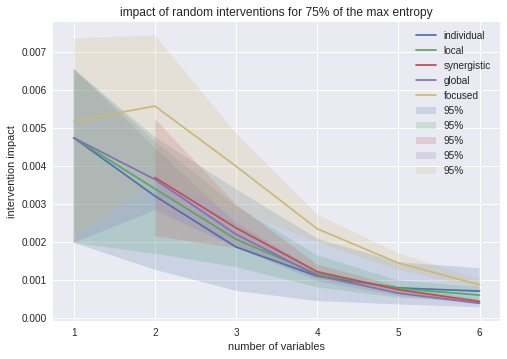

In [19]:
NUMBER_OF_STATES = 3
DIST_START, DIST_END = 100, 200
PERCENTAGE_MAX_ENTROPY_SIZE = 75

nudge_types = ["individual", "local", "synergistic", "global", "focused"]
# nudge_types = ["individual", "local", "synergistic", "global"]
#nudge_types = ["local", "synergistic", "global"]
#nudge_types = ["synergistic", "global"]

numbers_of_var = [2, 3, 4, 5, 6, 7]
for nudge_type in nudge_types:
    print(nudge_type)
    var_to_impacts = {}
    for number_of_var in numbers_of_var:
        print(number_of_var)
        if nudge_type == "synergistic" and number_of_var==2:
            continue
        if (nudge_type == "local" or nudge_type == "global") and number_of_var==2:
            impacts = get_random_impacts(
                number_of_var, NUMBER_OF_STATES, PERCENTAGE_MAX_ENTROPY_SIZE, 
                "individual", DIST_START, DIST_END
            )
        else:
            impacts = get_random_impacts(
                number_of_var, NUMBER_OF_STATES, PERCENTAGE_MAX_ENTROPY_SIZE, 
                nudge_type, DIST_START, DIST_END
            )

        var_to_impacts[number_of_var] = impacts
        
#         #testing for normality 
#         print(stats.shapiro(impacts))
#         print(stats.normaltest(impacts))
#         sns.distplot(impacts)
#         plt.show()
        
    variable_range, mean, std, batches_std = (
        find_mean_std_mse(var_to_impacts, 10)
    )
    std2 = list(2*np.array(std))
#     plot_mean_and_confidence(variable_range, mean, nudge_type, std2, None)
    
    #add confidence intervals based on percentiles
    lower_bound, median, upper_bound = [], [], []
    for variable_number, impacts in var_to_impacts.items():
        lower_bound.append(np.percentile(impacts, 2.5))
        median.append(np.median(impacts)) 
        upper_bound.append(np.percentile(impacts, 97.5))
        
    plot_range = [i-1 for i in list(var_to_impacts.keys())]
    plt.plot(plot_range, median, label=nudge_type)
    plt.fill_between(plot_range, lower_bound, upper_bound, 
                     label='{}'.format("95%"), alpha=0.2)

    
plt.xlabel("number of variables")
plt.ylabel("intervention impact")
plt.title("impact of random interventions for {}% of the max entropy".format(PERCENTAGE_MAX_ENTROPY_SIZE))
plt.legend()
plt.show()


individual
2
3
4
5
6
7
local
2
3
4
5
6
7
synergistic
2
3
4
5
6
7
global
2
3
4
5
6
7
focused
2
3
4
5
6
7


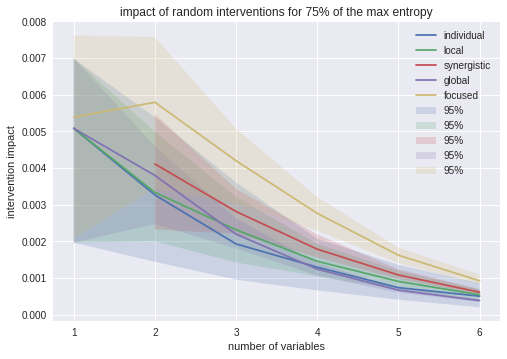

In [20]:
def get_random_impacts_validate(number_of_vars, number_of_states, percentage_max_entropy_size, 
                       nudge_type, dist_start, dist_end):
    
    filename_to_save_impacts =  "random_impacts_validate_{}var_{}states_{}entropy_{}_nudge_dists{}-{}.json".format(
        number_of_vars, number_of_states, percentage_max_entropy_size, nudge_type, dist_start, dist_end 
    )
    with open("data_experiments/" + filename_to_save_impacts, 'r') as f:
        impacts = json.load(f)
        
    return impacts

NUMBER_OF_STATES = 3
DIST_START, DIST_END = 200, 300
PERCENTAGE_MAX_ENTROPY_SIZE = 75

nudge_types = ["individual", "local", "synergistic", "global", "focused"]
# nudge_types = ["individual", "local", "synergistic", "global"]
#nudge_types = ["local", "synergistic", "global"]
#nudge_types = ["synergistic", "global"]

numbers_of_var = [2, 3, 4, 5, 6, 7]
for nudge_type in nudge_types:
    print(nudge_type)
    var_to_impacts = {}
    for number_of_var in numbers_of_var:
        print(number_of_var)
        if nudge_type == "synergistic" and number_of_var==2:
            continue
        if (nudge_type == "local" or nudge_type == "global") and number_of_var==2:
            impacts = get_random_impacts_validate(
                number_of_var, NUMBER_OF_STATES, PERCENTAGE_MAX_ENTROPY_SIZE, 
                "individual", DIST_START, DIST_END
            )
        else:
            impacts = get_random_impacts_validate(
                number_of_var, NUMBER_OF_STATES, PERCENTAGE_MAX_ENTROPY_SIZE, 
                nudge_type, DIST_START, DIST_END
            )

        var_to_impacts[number_of_var] = impacts
        
#         #testing for normality 
#         print(stats.shapiro(impacts))
#         print(stats.normaltest(impacts))
#         sns.distplot(impacts)
#         plt.show()
        
    variable_range, mean, std, batches_std = (
        find_mean_std_mse(var_to_impacts, 10)
    )
    std2 = list(2*np.array(std))
#     plot_mean_and_confidence(variable_range, mean, nudge_type, std2, None)
    
    #add confidence intervals based on percentiles
    lower_bound, median, upper_bound = [], [], []
    for variable_number, impacts in var_to_impacts.items():
        lower_bound.append(np.percentile(impacts, 2.5))
        median.append(np.median(impacts)) 
        upper_bound.append(np.percentile(impacts, 97.5))
        
    plot_range = [i-1 for i in list(var_to_impacts.keys())]
    plt.plot(plot_range, median, label=nudge_type)
    plt.fill_between(plot_range, lower_bound, upper_bound, 
                     label='{}'.format("95%"), alpha=0.2)

    
plt.xlabel("number of variables")
plt.ylabel("intervention impact")
plt.title("impact of random interventions for {}% of the max entropy".format(PERCENTAGE_MAX_ENTROPY_SIZE))
plt.legend()
plt.show()




### Combine data experiment impact on MI of minimalizing individual nudge impact

In [21]:
def load_files_json(file_names):
    dicts = []
    for file_name in file_names:
        with open(file_name, 'r') as f:
            dicts.append(json.load(f))
            
    return dicts

def update_dictkeys_unicode2string(dictionary):
    return {str(k):v for k,v in dictionary.items()}

def combine_data_dicts(dictionaries):
    """
    Combine data dicts, meaning that all data of the same key are merged into a new dict
    
    Parameters:
    ----------
    dictionaries: a list of dicts
        Every key of the dicts should have a list as values 

    """
    new_dict = {}
    for dictionary in dictionaries:
        for key, values in dictionary.items():
            if key in new_dict:
                new_dict[key].extend(values)
            else:
                new_dict[key] = values
                
    return new_dict

def get_average_values_dict(dictionary):
    """take average of all values dictionary"""
    return {k:np.mean(v) for k, v in dictionary.items()}

#for 2 input vars with 5 states
file_name_format2 = "minimize_individual_focused_nudge_impact_kl_divergence_inspect_change_MI_2var_5states{}.json"
files_vars2 = [PATH + file_name_format2.format(i) for i in ["", 1, 3, 4, 5, 6]]
dictionaries_vars2 = load_files_json(files_vars2)
dictionaries_vars2 = [update_dictkeys_unicode2string(dictionary) for dictionary in dictionaries_vars2]
dictionary_vars2 = combine_data_dicts(dictionaries_vars2)
print(get_average_values_dict(dictionary_vars2))

#for 3 input vars with 5 states
file_name_format3 = "minimize_individual_focused_nudge_impact_inspect_change_MI_3var_5states{}.json"
files_vars3 = [PATH + file_name_format3.format(i) for i in ["", 2, 3, 4, 5]]
dictionaries_vars3 = load_files_json(files_vars3)
dictionaries_vars3 = [update_dictkeys_unicode2string(dictionary) for dictionary in dictionaries_vars3]
dictionary_vars3 = combine_data_dicts(dictionaries_vars3)
print(get_average_values_dict(dictionary_vars3))

#something is wrong !!! mutual information 4 variables waay to high
file_vars4 = "minimize_individual_focused_nudge_impact_inspect_change_MI_4var_5states.json"
dictionaries_vars4 = load_files_json([PATH + file_vars4])
dictionary_vars4 = update_dictkeys_unicode2string(dictionaries_vars4[0])
print(get_average_values_dict(dictionary_vars4))

{'impact_after': 3.007298611341186e-05, 'mi_after': 0.14667514319890104, 'impact_before': 5.7637418943678235e-05, 'mi_before': 0.21959086454706087}
{'impact_after': 7.172282444333051e-06, 'mi_after': 0.054871355930750675, 'impact_before': 1.2987512109998274e-05, 'mi_before': 0.070452646416604744}
{'impact_after': 1.5486815215445593e-06, 'mi_before': 0.019623418020733245, 'impact_before': 2.2681870853415616e-06, 'mi_after': 0.017394584143839334}


### Correlation MI and individual nudge impact

In [ ]:
def load_data_correlation_MI_nudge_impact(var_to_file_names, multiple_files4=False):
    """
    Parameters:
    ----------
    var_to_files: a dict
    
    """
    var_to_MI_and_nudge_impact = {}
    for number_of_var, file_names in var_to_file_names.items():
        file_names = [PATH+file_name for file_name in file_names]
        if number_of_var == 5 or (number_of_var == 4 and multiple_files4):
            mi_and_nudge_impact_lists = load_files_json(file_names)
            var_to_MI_and_nudge_impact[number_of_var] = [
                list(itertools.chain.from_iterable(mi_and_nudge_impact_lists))
            ]
        else:
            var_to_MI_and_nudge_impact[number_of_var] = load_files_json(file_names)[0]

    return var_to_MI_and_nudge_impact

focused_nudge_kl_divergence_impact_and_MI_var_to_files = {
    1: ["correlation_MI_individual_nudge_impact_1var_5states_min_output001_ex1.json"],
    2: ["correlation_MI_individual_nudge_impact_2var_5states_min_output001_ex2.json"],
    3: ["correlation_MI_individual_nudge_impact_3var_5states_min_output001_exp3.json"],
    4: ["correlation_MI_individual_nudge_impact_4var_5states_min_output001_exp4.json"],
    5: [
        "correlation_MI_individual_nudge_impact_5var_5states_min_output001_exp5_points0_20.json",
        "correlation_MI_individual_nudge_impact_5var_5states_min_output001_exp6_point20_40.json",
        "correlation_MI_individual_nudge_impact_5var_5states_min_output001_exp3_points40_60.json",
        "correlation_MI_individual_nudge_impact_5var_5states_min_output001_ex2_points60_80.json",
        "correlation_MI_individual_nudge_impact_5var_5states_min_output001_ex1_points80_100.json"
    ]
}

focused_nudge_kl_divergence_impact_and_MI_var_to_files2 = {
    1: ["correlation_MI_individual_nudge_impact_1var_5states_min_output001_ex1_0_300.json"],
    2: ["correlation_MI_individual_nudge_impact_2var_5states_min_output001_ex3_0_300.json"],
    3: ["correlation_MI_individual_nudge_impact_3var_5states_min_output001_ex1_0_300.json"],
    4: [
        "correlation_MI_individual_nudge_impact_4var_5states_min_output001_exp4.json",
        "correlation_MI_individual_nudge_impact_4var_5states_min_output001_ex4_200_250.json",
        "correlation_MI_individual_nudge_impact_4var_5states_min_output001_ex5_250_300.json"
    ],
    5: [
        "correlation_MI_individual_nudge_impact_5var_5states_min_output001_exp5_points0_20.json",
        "correlation_MI_individual_nudge_impact_5var_5states_min_output001_exp6_point20_40.json",
        "correlation_MI_individual_nudge_impact_5var_5states_min_output001_exp3_points40_60.json",
        "correlation_MI_individual_nudge_impact_5var_5states_min_output001_ex2_points60_80.json",
        "correlation_MI_individual_nudge_impact_5var_5states_min_output001_ex1_points80_100.json"
    ]
}

focused_nudge_l1norm_impact_and_MI_var_to_files = {
    1: ["correlation_MI_individual_nudge_impact_1var_5states_l1norm_ex1.json"],
    2: ["correlation_MI_individual_nudge_impact_2var_5states_l1norm_ex2.json"],
    3: ["correlation_MI_individual_nudge_impact_3var_5states_l1norm_exp3.json"],
    4: [
        "correlation_MI_individual_nudge_impact_4var_5states_l1norm_exp4.json",
        "correlation_MI_individual_nudge_impact_4var_5states_l1norm_exp1_200_250.json",
        "correlation_MI_individual_nudge_impact_4var_5states_l1norm_exp2_250_300.json"
    ],
    5: [
        "correlation_MI_individual_nudge_impact_5var_5states_l1norm_exp5_points0_20.json",
        "correlation_MI_individual_nudge_impact_5var_5states_l1norm_exp6_point20_40.json",
        "correlation_MI_individual_nudge_impact_5var_5states_l1norm_ex1_points40_60.json",
        "correlation_MI_individual_nudge_impact_5var_5states_l1norm_ex2_points60_80.json",
        "correlation_MI_individual_nudge_impact_5var_5states_l1norm_ex1_points80_90.json",
        "correlation_MI_individual_nudge_impact_5var_5states_l1norm_ex2_points90_100.json"
    ]
}

vector_nudge_kl_divergence_impact_and_MI_var_to_files = {
    1: ["correlation_MI_individual_vector_nudge_impact_1var_5states_min_output001_ex1.json"],
    2: ["correlation_MI_individual_vector_nudge_impact_2var_5states_kl-divergence_ex2.json"],
    3: ["correlation_MI_individual_vector_nudge_impact_3var_5states_kl-divergence_ex1.json"],
    4: ["correlation_MI_individual_vector_nudge_impact_4var_5states_kl-divergence_ex2.json"],
    5: [
        "correlation_MI_individual_vector_nudge_impact_5var_5states_kl-divergence_ex3_points0_30.json",
        "correlation_MI_individual_vector_nudge_impact_5var_5states_kl-divergence_ex1_points30_60.json",
        "correlation_MI_individual_vector_nudge_impact_5var_5states_kl-divergence_ex1_points60_70.json",
        "correlation_MI_individual_vector_nudge_impact_5var_5states_kl-divergence_ex2_points70_80.json",
        "correlation_MI_individual_vector_nudge_impact_5var_5states_kl-divergence_ex3_points80_90.json",
        "correlation_MI_individual_vector_nudge_impact_5var_5states_kl-divergence_ex4_points90_100.json"
    ]
}

vector_nudge_l1norm_impact_and_MI_var_to_files = {
    1: ["correlation_MI_individual_vector_nudge_impact_1var_5states_l1norm_ex1.json"],
    2: ["correlation_MI_individual_vector_nudge_impact_2var_5states_l1norm_ex2.json"],
    3: ["correlation_MI_individual_vector_nudge_impact_3var_5states_l1norm_ex3.json"],
    4: ["correlation_MI_individual_vector_nudge_impact_4var_5states_l1norm_ex4.json"],
    5: [
        "correlation_MI_individual_vector_nudge_impact_5var_5states_l1norm_ex5_point0_30.json",
        "correlation_MI_individual_vector_nudge_impact_5var_5states_l1norm_exp6_points30_60.json",
        "correlation_MI_individual_vector_nudge_impact_5var_5states_l1norm_ex5_point60_90.json",
        "correlation_MI_individual_vector_nudge_impact_5var_5states_l1norm_exp6_points90_120.json"
    ]
}

var_to_focused_nudge_kl_divergence_impact_and_MI = load_data_correlation_MI_nudge_impact(
    focused_nudge_kl_divergence_impact_and_MI_var_to_files2, True
)

var_to_focused_nudge_l1norm_impact_and_MI = load_data_correlation_MI_nudge_impact(
    focused_nudge_l1norm_impact_and_MI_var_to_files, True
)

var_to_vector_nudge_kl_divergence_impact_and_MI = load_data_correlation_MI_nudge_impact(
    vector_nudge_kl_divergence_impact_and_MI_var_to_files
)

var_to_vector_nudge_l1norm_impact_and_MI = load_data_correlation_MI_nudge_impact(
    vector_nudge_l1norm_impact_and_MI_var_to_files
)



In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

#### Plot correlations

In [ ]:
#import seaborn as sns
#add seaborn linregress on own computer

# dict_to_use = var_to_focused_nudge_kl_divergence_impact_and_MI
# dict_to_use = var_to_focused_nudge_l1norm_impact_and_MI
dict_to_use = var_to_vector_nudge_kl_divergence_impact_and_MI
# dict_to_use = var_to_vector_nudge_l1norm_impact_and_MI

for var, impact_nudges_and_mi in dict_to_use.items():
    if var == 5:
#     if var == 5 or var ==4:
        impact_nudges_and_mi=impact_nudges_and_mi[0]

    impact_nudges = [item[0] for item in impact_nudges_and_mi] 
    mutual_information_sizes = [item[1] for item in impact_nudges_and_mi]
        
#   testing for normality 
    print(stats.shapiro(impact_nudges))
    print(stats.normaltest(impact_nudges))
    stats.probplot(impact_nudges, dist="norm", plot=plt)
    plt.show()
    sns.distplot(impact_nudges)
    plt.show()

        
    plt.plot(mutual_information_sizes, impact_nudges, 'o')
    plt.xlabel("mutual information")
    plt.ylabel("nudge impact")
    plt.show()
    print(stats.linregress(impact_nudges, mutual_information_sizes))
    print("spearman")
    print(stats.spearmanr(impact_nudges, mutual_information_sizes))


In [ ]:
import seaborn as sns
import pandas as pd

# dict_to_use = var_to_focused_nudge_kl_divergence_impact_and_MI
dict_to_use = var_to_focused_nudge_l1norm_impact_and_MI
# dict_to_use = var_to_vector_nudge_kl_divergence_impact_and_MI
# dict_to_use = var_to_vector_nudge_l1norm_impact_and_MI

for var, impact_nudges_and_mi in dict_to_use.items():
    #if var == 5:
    if var == 5 or var ==4:
        impact_nudges_and_mi = impact_nudges_and_mi[0]       
        impact_nudges = [item[0] for item in impact_nudges_and_mi]
        print(len(impact_nudges))
        mutual_information_sizes = [item[1] for item in impact_nudges_and_mi]
    else:
        impact_nudges = [item[0] for item in impact_nudges_and_mi] 
        print(len(impact_nudges))
        mutual_information_sizes = [item[1] for item in impact_nudges_and_mi]

    
#     df = pd.DataFrame({"mutual information": mutual_information_sizes, "l1-norm impact": impact_nudges}) 
#     sns.regplot("mutual information", "l1-norm impact", df)
    df = pd.DataFrame({"mutual information": mutual_information_sizes, "KL-divergence impact": impact_nudges}) 
    sns.regplot("mutual information", "KL-divergence impact", df)
    plt.title("correlation mutual information and causal power")
    sns.plt.show()
    print(stats.linregress(impact_nudges, mutual_information_sizes))


### After removing outliers

In [ ]:
#import seaborn as sns
#add seaborn linregress on own computer

focused_nudges = var_to_focused_nudge_kl_divergence_impact_and_MI
focused_nudges[1] = [i for i in focused_nudges[1] if i[0] < 0.00025]

vector_nudges = var_to_vector_nudge_kl_divergence_impact_and_MI
vector_nudges[1] = [i for i in vector_nudges[1] if i[0] < 0.00006]

for var, impact_nudges_and_mi in focused_nudges.items():
    if var == 5:
        impact_nudges_and_mi=impact_nudges_and_mi[0]

    impact_nudges = [item[0] for item in impact_nudges_and_mi] 
    mutual_information_sizes = [item[1] for item in impact_nudges_and_mi]
        
    #   testing for normality 
    print(stats.shapiro(impact_nudges))
    print(stats.normaltest(impact_nudges))
    sns.distplot(impact_nudges)
    plt.show()
        
    plt.plot(mutual_information_sizes, impact_nudges, 'o')
    plt.xlabel("mutual information")
    plt.ylabel("nudge impact")
    plt.show()
    print(stats.linregress(impact_nudges, mutual_information_sizes))


#### Relation MI and nudge impact for 1 input and 1 output 

In [ ]:
from collections import OrderedDict

def plot_nudge_impact_given_mi(data_dict, title, ylabel, yrange=None):
    plot_range, mean, std, batches_std = find_mean_std_mse(data_dict, batch_size=1)
    lower_bound = np.array(mean) - 2*np.array(std)
    upper_bound = np.array(mean) + 2*np.array(std)
    plt.plot(plot_range, mean, label="mean")
    plt.fill_between(plot_range, lower_bound, upper_bound, 
                     label='{}'.format("std"),
                     alpha=0.2)

    plt.xlabel("mutual information")
    plt.ylabel(ylabel)
    #plt.legend()
    plt.title(title)
    if yrange:
        plt.ylim(yrange)
    
    plt.show()

    print(stats.linregress(np.array(plot_range), np.array(mean)))

def string_keys_to_numbers(data_dict):
    for mi_value, values in data_dict.items():
        data_dict[round((float(mi_value)*100.0))/100.0] = values
        data_dict.pop(mi_value, None)
    
    return data_dict
    
#load the data
with open("data_experiments/individual_nudge_impact_kl_divergence_focused_given_MI2.json", 'r') as f:
    focused_kl_divergence = json.load(f)
    
with open("data_experiments/individual_nudge_impact_l1norm_focused_given_MI2.json", 'r') as f:
    focused_l1norm = json.load(f)

with open("data_experiments/individual_nudge_impact_kl_divergence_vector_given_MI2.json", 'r') as f:
    vector_kl_divergence = json.load(f)

with open("data_experiments/individual_nudge_impact_absolute_vector_given_MI2.json", 'r') as f:
    vector_l1norm = json.load(f)
    
focused_kl_divergence = string_keys_to_numbers(focused_kl_divergence)
focused_l1norm = string_keys_to_numbers(focused_l1norm)
vector_kl_divergence = string_keys_to_numbers(vector_kl_divergence)
vector_l1norm = string_keys_to_numbers(vector_l1norm)

def plot_median_95_percent_confidence_interval(vars_to_values, yrange=None, xlabel=None, ylabel=None,
                                               title=None):
    """
    Parameters:
    ----------
    values_dict: a dict where every variable has a list as values 
    
    """
    vars_to_values = OrderedDict(sorted(vars_to_values.items(), key=lambda x: x[0]))
    #add confidence intervals based on percentiles
    lower_bound, median, mean, upper_bound = [], [], [], []
    for mutual_information, impacts in vars_to_values.items():
        lower_bound.append(np.percentile(impacts, 2.5))
        median.append(np.median(impacts)) 
        mean.append(np.mean(impacts))
        upper_bound.append(np.percentile(impacts, 97.5))

    plot_range = sorted(list(focused_kl_divergence.keys()))
    print(title)
    print(stats.linregress(mean, plot_range))
    print(stats.spearmanr(mean, plot_range))
    
    plt.plot(plot_range, median, label="median")
    plt.fill_between(plot_range, lower_bound, upper_bound, 
                     label='{}'.format("95%"), alpha=0.2)
    if yrange:
        plt.ylim(yrange)
        
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    if title:
        plt.title(title)
    
    plt.show()
    
plot_median_95_percent_confidence_interval(
    focused_kl_divergence, (0, 0.0002), xlabel="mutual information", ylabel="KL-divergence",
    title="relation mutual information and focused intervention impact" 
)
plot_median_95_percent_confidence_interval(
    focused_l1norm, xlabel="mutual information", ylabel="l1-norm",
    title="relation mutual information and focused intervention impact"
)
plot_median_95_percent_confidence_interval(
    vector_kl_divergence, (0, 0.000125), xlabel="mutual information", ylabel="KL-divergence",
    title="relation mutual information and individual intervention impact"
)
plot_median_95_percent_confidence_interval(
    vector_l1norm, xlabel="mutual information", ylabel="l1-norm",
    title="relation mutual information and individual intervention impact"
)

#confidence intervals based on mean and standard deviations
# plot_nudge_impact_given_mi(
#     focused_kl_divergence, 
#     "impact of focused interventions for a fixed mutual information", 
#     "KL-divergence impact",
#     (-0.00005, 0.0002)
# )

# plot_nudge_impact_given_mi(
#     focused_l1norm, "impact of focused interventions for a fixed mutual information", "l1-norm impact"
# )
# plot_nudge_impact_given_mi(
#     vector_kl_divergence, 
#     "impact of individual interventions for a fixed mutual information", 
#     "KL-divergence impact",
#     (-0.00004, 0.00012)
# )
# plot_nudge_impact_given_mi(
#     vector_l1norm, "impact of individual interventions for a fixed mutual information", "l1-norm impact"
# )
    

In [ ]:
with open("data_experiments/individual_nudge_impact_kl_divergence_focused_given_MI2.json", 'r') as f:
    focused_kl_divergence = json.load(f)
    
with open("data_experiments/individual_nudge_impact_kl_divergence_vector_given_MI2.json", 'r') as f:
    vector_kl_divergence = json.load(f)
    
focused_kl_divergence = string_keys_to_numbers(focused_kl_divergence)
vector_kl_divergence = string_keys_to_numbers(vector_kl_divergence)

print(np.array(focused_kl_divergence[0.85]))
print(np.array(vector_kl_divergence[0.85]))
focused_kl_divergence[0.85] = [i for i in focused_kl_divergence[0.85] if i < 1e-03]
vector_kl_divergence[0.85] = [i for i in vector_kl_divergence[0.85] if i < 1e-04]

plot_nudge_impact_given_mi(
    focused_kl_divergence, "focused nudge impact for a fixed mutual information cleaned data", "nudge impact (KL-divergence)"
)
plot_nudge_impact_given_mi(
    vector_kl_divergence, "vector nudge impact for a fixed mutual information cleaned data", "nudge impact (KL-divergence)"
)


In [ ]:
with open("data_experiments/relation_MI_nudge_impact_1input_non_biased1.json", 'r') as f:
    data_dict = json.load(f)

with open("data_experiments/relation_MI_nudge_impact_1input_non_biased2.json", 'r') as f:
    data_dict1 = json.load(f)
    
for mi_value, values in data_dict1.items():
    data_dict1[round((float(mi_value)*1000.0))/1000.0] = values
    data_dict1.pop(mi_value, None)
    
for mi_value, values in data_dict.items():
    data_dict[round((float(mi_value)*100.0))/100.0] = values
    data_dict.pop(mi_value, None)
    
data_dict.update(data_dict1)

In [ ]:
print({k:len(v) for k,v in data_dict.items()})
plot_range, mean, std, batches_std = find_mean_std_mse(data_dict, batch_size=1)
print(np.array(data_dict[0.85]))

In [ ]:
lower_bound = np.array(mean)-np.array(std)
upper_bound = np.array(mean)+np.array(std)
print(lower_bound)
print(upper_bound)
print(plot_range)
plt.plot(plot_range, mean, label="mean")
plt.fill_between(plot_range, lower_bound, upper_bound, 
                 label='{}'.format("std"),
                 alpha=0.2)

plt.xlabel("mutual information")
plt.ylabel("KL-divergence")
#plt.legend()
plt.title('Individual nudge impact for set mutual information')
plt.show()

stats.linregress(np.array(plot_range), np.array(mean))

In [ ]:
data_dict[0.85] = [i for i in data_dict[0.85] if i < 1e-03]
print(np.array(data_dict[0.85]))

In [ ]:
plot_range, mean, std, batches_std = find_mean_std_mse(data_dict, batch_size=1)
lower_bound = np.array(mean)-np.array(std)
upper_bound = np.array(mean)+np.array(std)
print(lower_bound)
print(upper_bound)
print(plot_range)
plt.plot(plot_range, mean, label="mean")
plt.fill_between(plot_range, lower_bound, upper_bound, 
                 label='{}'.format("std"),
                 alpha=0.2)

plt.xlabel("mutual information")
plt.ylabel("KL-divergence")
#plt.legend()
plt.title('Individual nudge impact for set mutual information')
plt.show()

stats.linregress(np.array(plot_range), np.array(mean))

### Make correlation plots

In [ ]:
def confidence_interval_r2(correlation, N, confidence_interval):
    z = np.arctanh(correlation)
    sigma = (1/((N-3)**0.5))
    #print(sigma)

    cint = z + np.array([-1, 1]) * sigma * stats.norm.ppf((1+confidence_interval)/2)
    return np.tanh(cint)

correlation = 0.711
N = 300
confidence_interval = 0.95
confidence_interval_r2(correlation, N, confidence_interval)

In [ ]:

def produce_lower_upper_bound(correlations, sample_numbers):
    confidence_intervals = [confidence_interval_r2(correlation, samples, 0.95) for correlation, samples 
                            in zip(correlations, sample_numbers)]
    confidence_intervals = [list(i) for i in confidence_intervals]
    lower_bound, upper_bound = zip(*confidence_intervals)
    return lower_bound, upper_bound
    
print(produce_lower_upper_bound(focused_l1norm_correlations, [300, 300, 300, 300, 100]))

In [ ]:

input_vars = [1, 2, 3, 4, 5]
focused_l1norm_correlations = [0.711, 0.5359, 0.5378, 0.5200, 0.5209]
focused_kl_divergence_correlations = [0.2810, 0.4102, 0.5124, 0.5014, 0.5729]
vector_l1norm_correlations = [0.762, 0.7241, 0.6156, 0.576, 0.4808]
vector_kl_divergence_correlations = [0.2424, 0.6589, 0.6628, 0.5299, 0.5707]


plt.plot(input_vars, focused_l1norm_correlations)
lower_bound, upper_bound = produce_lower_upper_bound(focused_l1norm_correlations, [300, 300, 300, 300, 100])
plt.fill_between(input_vars, lower_bound, upper_bound, 
                 label='{}'.format("95%"),
                 alpha=0.2)
plt.xlabel("number of input variables")
plt.ylabel("correlation MI and causal power")
plt.show()

plt.plot(input_vars, focused_kl_divergence_correlations)
lower_bound, upper_bound = produce_lower_upper_bound(focused_kl_divergence_correlations, [300, 300, 300, 300, 100])
plt.fill_between(input_vars, lower_bound, upper_bound, 
                 label='{}'.format("95%"),
                 alpha=0.2)
plt.xlabel("number of input variables")
plt.ylabel("correlation MI and causal power")
plt.show()

#produce the plot for vector interventions measured with the l1-norm
plt.plot(input_vars, vector_l1norm_correlations)
lower_bound, upper_bound = produce_lower_upper_bound(vector_l1norm_correlations, [300, 300, 300, 300, 100])
plt.fill_between(input_vars, lower_bound, upper_bound, 
                 label='{}'.format("95%"),
                 alpha=0.2)
plt.xlabel("number of input variables")
plt.ylabel("correlation MI and causal power")
plt.show()


plt.plot(input_vars, vector_kl_divergence_correlations)
lower_bound, upper_bound = produce_lower_upper_bound(vector_kl_divergence_correlations, [300, 300, 300, 300, 100])
plt.fill_between(input_vars, lower_bound, upper_bound, 
                 label='{}'.format("95%"),
                 alpha=0.2)
plt.xlabel("number of input variables")
plt.ylabel("correlation MI and causal power")
plt.show()

### Show output marginal has less states with low probability as number of variables increases

In [ ]:
import seaborn as sb
#based on 1000 distributions
def dict_keys_from_string_to_int(dictionary):
    return {int(k):v for k,v in dictionary.items()}


filename ="/home/derkjan/Documents/academics_UVA/master_thesis/code/data_experiments/states_below_0.1.json"
with open(filename, 'r') as f:
    number_of_vars_to_low_probable_states = json.load(f)
    
number_of_vars_to_low_probable_states = dict_keys_from_string_to_int(number_of_vars_to_low_probable_states)
print(number_of_vars_to_low_probable_states)

plt.plot(number_of_vars_to_low_probable_states.keys(), number_of_vars_to_low_probable_states.values())
plt.xlabel("number of variables")
plt.ylabel("number of output marginals below 0.1")
plt.show()



In [ ]:
filename ="/home/derkjan/Documents/academics_UVA/master_thesis/code/data_experiments/distances_output_uniform.json"
with open(filename, 'r') as f:
    number_of_vars_to_distance_output_uniform = json.load(f)
    
variable_range, mean, std, batches_std = (
    find_mean_std_mse(number_of_vars_to_distance_output_uniform, 30)
)
print(mean)
print(std)
lower_bound = np.array(mean) - 2*np.array(batches_std)
upper_bound = np.array(mean) + 2*np.array(batches_std)

print(lower_bound)
print(upper_bound)

plt.plot(range(1,6,1), mean)
plt.fill_between(range(1,6,1), lower_bound, upper_bound, 
                 label='{}'.format("95%"),
                 alpha=0.2)
plt.xlabel("number of variables")
plt.ylabel("distance to uniform distribution")
plt.legend()
plt.show()